In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import get_data
import statsmodels
from simulate import simulatedata

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=695704595703-kho1v4q5lhtoqq268ckb4it0n08facat.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
syms = ['BTCUSDT']
freq = '10min'
start_date = '2020-01-01'
end_date = '2021-01-01'

In [4]:
raw_data = get_data.get_data(syms, freq, start_date, end_date)
raw_data

{'BTCUSDT':                                open      high       low     close      volume  \
 time                                                                            
 2020-01-01 00:00:00+00:00   7195.24   7196.25   7178.20   7191.07  154.874358   
 2020-01-01 00:10:00+00:00   7193.15   7193.53   7177.35   7178.29   80.261439   
 2020-01-01 00:20:00+00:00   7177.71   7185.56   7175.47   7178.45   96.049725   
 2020-01-01 00:30:00+00:00   7178.19   7185.44   7176.23   7177.53   59.973326   
 2020-01-01 00:40:00+00:00   7177.14   7182.99   7176.34   7182.94   44.872982   
 ...                             ...       ...       ...       ...         ...   
 2021-01-01 23:10:00+00:00  29276.84  29297.00  29228.14  29297.00  184.771042   
 2021-01-01 23:20:00+00:00  29296.99  29309.90  29254.11  29276.25  116.364350   
 2021-01-01 23:30:00+00:00  29276.24  29328.00  29267.60  29320.00  173.961308   
 2021-01-01 23:40:00+00:00  29320.00  29325.89  29252.60  29277.35  163.284983   
 2021

In [5]:
dt = pd.DataFrame()
dt['close'] = raw_data['BTCUSDT']['close']
dt['ret'] = raw_data['BTCUSDT']['close'].pct_change()
dt

,close,ret
time,,
2020-01-01 00:00:00+00:00,7191.07,NaN
2020-01-01 00:10:00+00:00,7178.29,-0.001777
2020-01-01 00:20:00+00:00,7178.45,0.000022
2020-01-01 00:30:00+00:00,7177.53,-0.000128
2020-01-01 00:40:00+00:00,7182.94,0.000754
...,...,...
2021-01-01 23:10:00+00:00,29297.00,0.000689
2021-01-01 23:20:00+00:00,29276.25,-0.000708
2021-01-01 23:30:00+00:00,29320.00,0.001494


In [6]:
order, seasonal_order = simulatedata.get_order(dt)
order, seasonal_order

((7, 0, 6), (0, 0, 0, 1))

In [7]:
if sum(seasonal_order) == 1: seasonal_order = (0, 0, 0, 0)
model_params = simulatedata.fit_sarima(dt['ret'][1:], order, seasonal_order)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [30]:
t = simulatedata.simulate_sarima(dt['ret'][1:], order, seasonal_order, model_params, len(dt), 10)
t

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction resul

,0,1,2,3,4,5,6,7,8,9
0,-0.002536,0.000845,-0.005614,0.000847,0.000251,0.001987,-0.003886,0.002259,0.000562,-0.007297
1,-0.000451,-0.001595,0.005604,0.000952,0.002356,0.001206,0.004736,-0.001156,-0.003694,-0.004695
2,0.002396,0.000020,-0.003948,0.004988,0.003434,-0.008381,-0.000648,0.002962,0.003859,-0.004459
3,-0.001817,0.003374,0.002737,0.000867,-0.003520,-0.001655,-0.006169,-0.003515,-0.007851,-0.002734
4,0.000298,0.000605,0.004255,-0.000324,0.000584,0.001041,-0.000864,-0.006896,0.003759,0.000311
...,...,...,...,...,...,...,...,...,...,...
52714,0.010196,-0.003093,0.003020,0.004866,0.002122,-0.003337,0.005201,0.005986,0.000327,-0.002825
52715,0.002151,-0.001798,0.000774,0.006266,0.001261,-0.001141,-0.005533,-0.001779,0.000376,-0.004379
52716,0.003390,0.001096,0.003923,0.001352,0.002672,-0.003984,-0.002583,0.009308,0.003071,0.000153
52717,-0.003730,0.000952,-0.005569,0.001038,-0.003008,0.004529,0.004134,-0.008904,-0.003022,-0.000367


In [31]:
simulated_price_data = simulatedata.construct_price_series(t, dt['close'][0], dt.index[0], freq)

ValueError: x is required to have ndim 1 but has ndim 2

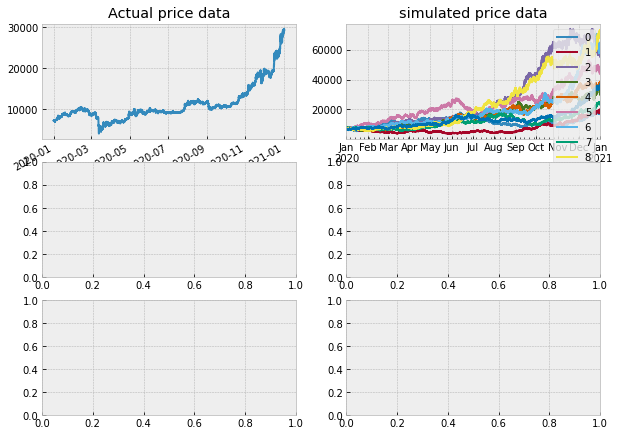

In [32]:
simulatedata.Evaluate_performance(dt['close'], simulated_price_data, lags=30)